In [13]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import scanpy as sc,anndata as ad
import os
import sys
import scipy as sp
from scipy.sparse import csr_matrix
from anndata import AnnData
import squidpy as sq

/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [50]:
data_type = "xenium_like_data/"
dataset = "complex/"
f"/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/simulations_for_sketching_analysis/{data_type}{dataset}counts.csv"

'/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/simulations_for_sketching_analysis/xenium_like_data/complex/counts.csv'

In [51]:
# 1) Read in your counts and metadata
# -----------------------------------
# counts.csv: rows=genes, cols=cells, first column is gene names
counts_df = pd.read_csv(f"/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/simulations_for_sketching_analysis/{data_type}{dataset}counts.csv", 
                        index_col=0)

# metadata.csv: rows=cells (Loc1,Loc2…), cols=features (x,y,group,foldchange…)
meta_df   = pd.read_csv(f"/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/simulations_for_sketching_analysis/{data_type}{dataset}metadata.csv", 
                        index_col=0)

# 2) Sanity‐check that the cell ordering matches
# -----------------------------------------------
# The columns of counts_df should be exactly the index of meta_df
assert list(counts_df.columns) == list(meta_df.index), \
       "Columns of counts and index of metadata must match exactly"

# 3) Build the sparse count matrix for AnnData
# ---------------------------------------------
# We want .X shape = (n_obs, n_vars) = (n_cells, n_genes)
# So transpose counts_df (it’s currently genes×cells → cells×genes)
X = counts_df.T.values
X_sparse = csr_matrix(X)

# 4) Create AnnData
# ------------------
#   obs: rows=cells → use meta_df
#   var: rows=genes → build a DataFrame with index=gene names
adata = AnnData(
    X   = X_sparse,
    obs = meta_df.copy(),
    var = pd.DataFrame(index=counts_df.index)
)

# 5) Stick your spatial coords into obsm['spatial']
# -------------------------------------------------
#   Here I assume your metadata has columns named exactly 'x' and 'y'
coords = meta_df[["x","y"]].values
adata.obsm["spatial"] = coords

# 6) Quick check
# --------------
print(adata)
# AnnData object with n_obs × n_vars = cells × genes
# .obs columns will be your metadata (including x,y,group,foldchange,…)
# .obsm['spatial'] will be an (n_cells, 2) array of x,y.

AnnData object with n_obs × n_vars = 99859 × 500
    obs: 'x', 'y', 'group', 'foldchange'
    obsm: 'spatial'


In [52]:
#now we will preprocess: 
# Saving count data
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


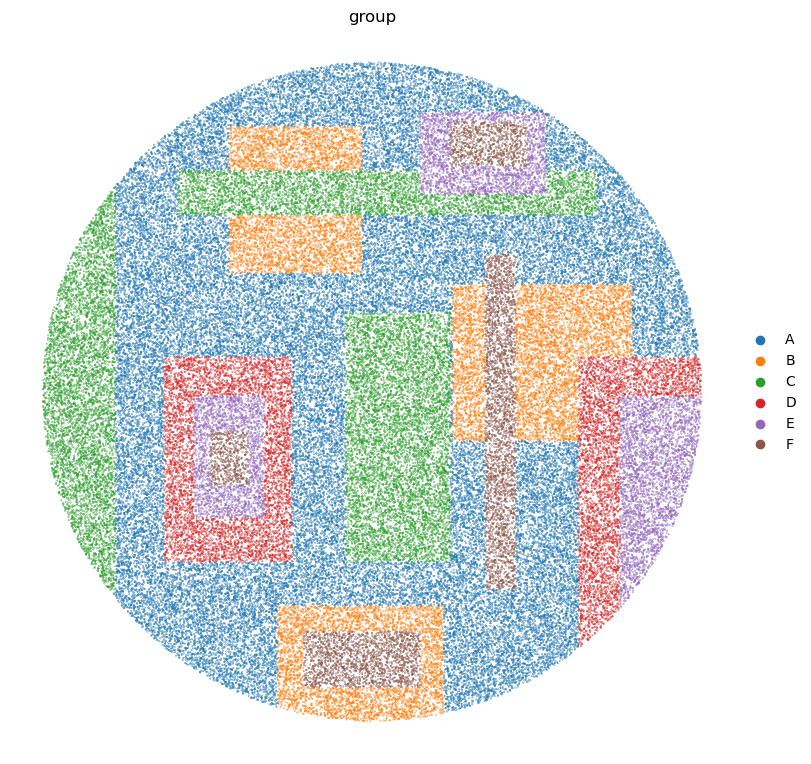

In [53]:
sq.pl.spatial_scatter(
    adata,
    frameon=False,
    shape=None,
    size = 0.1,
    color = ['group'],
    figsize = (8,8)
)

In [54]:
counts = adata.X.copy()
var_counts = adata.var.copy()
adata_counts_only = AnnData(X = counts,var = var_counts)
adata_counts_only

AnnData object with n_obs × n_vars = 99859 × 500

In [55]:
adata.write_h5ad(f"/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/simulations_for_sketching_analysis/{data_type}{dataset}processed_data.h5ad")
adata_counts_only.write_h5ad(f"/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/simulations_for_sketching_analysis/{data_type}{dataset}normalized_counts_only.h5ad")